In [12]:
%matplotlib inline

'''
Basic exploration of Baltimore 311 service requests.

Some questions we could ask:

  - Can we detect local bursts of similar calls? And if so, can we alert neighborhood organizations that requests are 
    being submitted? E.g., if nearby houses in a neighborhood are all calling about a burst pipe, potholes, etc.,
    could we tweet, email neighborhood lists, post on Nextdoor.com, etc.?

  - Is the city more responsive to some neighborhoods than others? 
    - How often are requests not resolved? 
    - How long does it take for requests to be resolved?
    - How does this vary with the type of request?

  - What are the top complaints for each neighborhood?
  
  - How requests correlate with weather, time of year, etc.?
    - Low water pressure / leaks over time?
    - Can multiple localized reports of low water pressure predict imminent bursts? 
      - Better data sources to ask this question?

  - Is there a trend over time for phone vs. internet requests?

References:
https://data.baltimorecity.gov/City-Services/311-Customer-Service-Requests/9agw-sxsr
'''

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# replace with the full path to your local source data
SRC_FILE = '/Users/macarlin/data/311_Customer_Service_Requests.csv'

In [3]:
# load the source data
df = pd.read_csv(SRC_FILE)
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'], format='%m/%d/%Y %I:%M:%S %p +0000')
df.set_index('CreatedDate', inplace=True)

/usr/local/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
# what are the headers of this csv?
list(df)

# how many rows?
df.shape

# what neighborhoods are represented?
neighborhoods = df['Neighborhood'].unique()

# what kinds of requests are we dealing with?
request_types = df['SRType'].unique()

print 'Found %s neighborhoods, %s request types' % (neighborhoods.shape[0], request_types.shape[0])
print sorted(neighborhoods)
print sorted(request_types)

Found 271 neighborhoods, 397 request types
['ABELL', 'ALLENDALE', 'ARCADIA', 'ARLINGTON', 'ARMISTEAD GARDENS', 'ASHBURTON', 'BALTIMORE HIGHLANDS', 'BALTIMORE-LINWOOD', 'BARCLAY', 'BARRE CIRCLE', 'BEECHFIELD', 'BELAIR-EDISON', 'BELAIR-PARKSIDE', 'BELLONA-GITTINGS', 'BEREA', 'BETTER WAVERLY', 'BEVERLY HILLS', 'BIDDLE STREET', 'BLYTHEWOOD', 'BOLTON HILL', 'BOOTH-BOYD', 'BREWERS HILL', 'BRIDGEVIEW/GREENLAWN', 'BROADWAY EAST', 'BROENING MANOR', 'BROOKLYN', 'BURLEITH-LEIGHTON', "BUTCHER'S HILL", 'CALLAWAY-GARRISON', 'CAMERON VILLAGE', 'CANTON', 'CANTON INDUSTRIAL AREA', 'CARROLL - CAMDEN INDUSTRIAL AREA', 'CARROLL PARK', 'CARROLL-SOUTH HILTON', 'CARROLLTON RIDGE', 'CEDARCROFT', 'CEDMONT', 'CEDONIA', 'CENTRAL FOREST PARK', 'CENTRAL PARK HEIGHTS', 'CHARLES NORTH', 'CHARLES VILLAGE', 'CHERRY HILL', 'CHESWOLDE', 'CHINQUAPIN PARK-BELVEDERE', 'CHRISTOPHER', 'CLAREMONT-FREEDOM', 'CLIFTON PARK', 'COLDSPRING', 'COLDSTREAM HOMESTEAD MONTEBELLO', 'CONCERNED CITIZENS OF FOREST PARK', 'COPPIN HEIGHTS/ASH

Text(0,0.5,'Count')

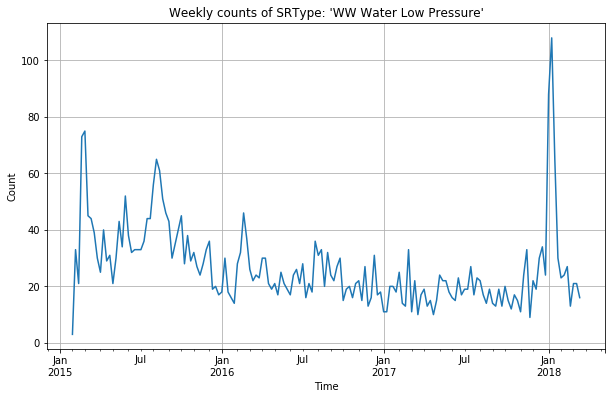

In [5]:
# visualize some activity over time for a specific category, binned by week
CATEGORY = 'WW Water Low Pressure'#'WW Water Leak (Exterior)'#'WW Hydrant Open'
gb = df.groupby('SRType')
gb_exterior_leaks = gb.get_group(CATEGORY).resample('W').count()

ax = gb_exterior_leaks['SRType'].plot(title='Weekly counts of SRType: \'%s\'' % CATEGORY,
                                     figsize=(10, 6),
                                     grid=True)
ax.set_xlabel('Time')
ax.set_ylabel('Count')

In [6]:
# let's use 'StatusDate' to estimate time to request resolution
# however, first need to convert to appropriate format to compare with 'CreatedDate'
df['StatusDate'] = pd.to_datetime(df['StatusDate'], format='%m/%d/%Y %I:%M:%S %p +0000') 

# compute resolution time in days for each request
df['ResolutionTime'] = (df['StatusDate']-df.index).astype('timedelta64[h]') / 24

Text(0,0.5,'Count')

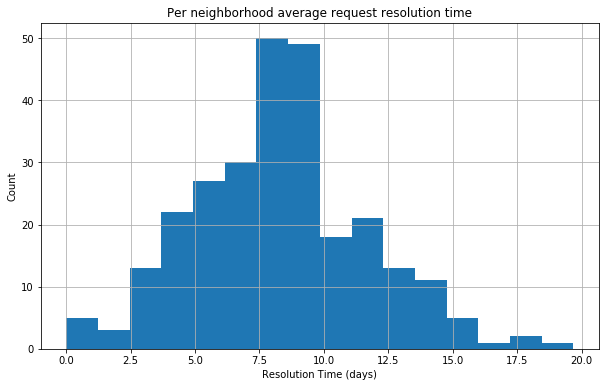

In [7]:
# Question: how does average request resolution time vary per neighborhood as a function of 
#  a) as completed requests (i.e., where SRStatus=='CLOSED') and 
#  b) for requests assigned to the Bureau of Solid Waste?
gb_neighborhood = df[(df.SRStatus=='CLOSED') & (df.Agency=='Bureau of Solid Waste')].groupby('Neighborhood')
avg_neighborhood_rt = gb_neighborhood['ResolutionTime'].mean()
ax = avg_neighborhood_rt.plot(kind='hist',
                              bins=int(np.sqrt(avg_neighborhood_rt.shape[0])),
                              title='Per neighborhood average request resolution time',
                              figsize=(10,6),
                              grid=True)
ax.set_xlabel('Resolution Time (days)')
ax.set_ylabel('Count')

In [8]:
# which neighborhoods had an average response time of at least two weeks?
avg_neighborhood_rt[avg_neighborhood_rt>14].sort_values()

Neighborhood
VILLAGES OF HOMELAND    14.240143
WEST FOREST PARK        14.377053
WAKEFIELD               14.387417
MOUNT HOLLY             14.651022
CEDARCROFT              14.672807
GWYNNS FALLS            15.143922
TOWANDA-GRANTLEY        15.293165
GARWYN OAKS             15.560110
CENTRAL PARK HEIGHTS    15.643187
FOREST PARK             15.733668
CARROLL PARK            16.834722
FRANKLINTOWN ROAD       17.389583
WOODBOURNE-MCCABE       17.553670
COLDSPRING              19.681721
Name: ResolutionTime, dtype: float64

Text(0,0.5,'Avg resolution time (days)')

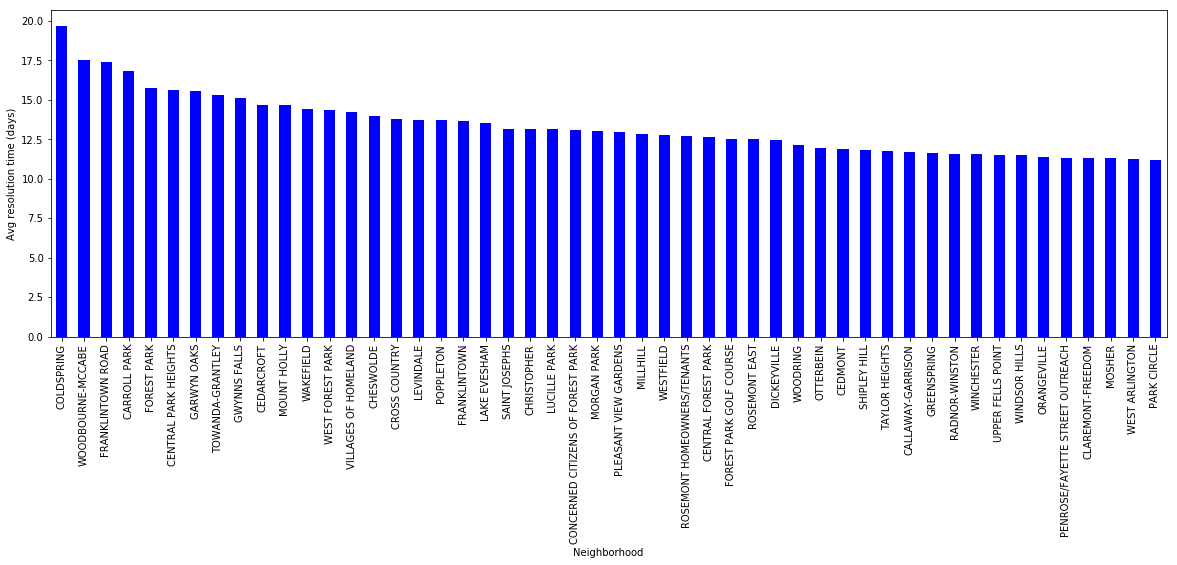

In [26]:
# bare bones summary visualization using a bar chart
ax = gb_neighborhood['ResolutionTime'].mean().sort_values(ascending=False).head(50).plot(kind='bar', 
                                                                                    color='b', 
                                                                                    figsize=(20,6))
ax.set_ylabel('Avg resolution time (days)')

In [28]:
df

,SRRecordID,ServiceRequesNum,SRType,Agency,Neighborhood,StreetAddress,ZipCode,MethodReceived,SRStatus,StatusDate,DueDate,LastActivity,Outcome,LastActivityDate,GeoLocation,ResolutionTime
CreatedDate,,,,,,,,,,,,,,,,
2015-02-01 08:12:00,1094344940,15-00072082,WW Water Leak (Exterior),Bureau of Water and Waste Water,CANTON,1013 S CLINTON ST,21224,Interface,CLOSED,2015-02-01 18:23:00,02/03/2015 08:12:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN,0.416667
2015-02-01 08:48:00,1094344982,15-00072083,BCLB-Liquor License Complaint,Liquor License Board,GREEKTOWN,500 S LEHIGH ST,21224,Interface,CLOSED,2015-02-18 21:12:00,03/21/2015 07:48:00 AM +0000,Dispatch Investigator,Closed,NaN,NaN,17.500000
2015-02-01 09:13:00,1094345013,15-00072084,WW Hydrant Open,Bureau of Water and Waste Water,MILLHILL,2600 WILKENS AVE,21223,Phone,HOLDLOCK,2015-02-01 11:07:00,02/02/2015 09:13:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN,0.041667
2015-02-01 09:24:00,1094345094,15-00072085,TRM-Snow/Icy Conditions,Department of Transportation,MEDFIELD,4496 83 N,21209,Phone,CLOSED,2015-02-04 22:41:00,02/02/2015 09:24:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN,3.541667
2015-02-01 09:29:00,1094345124,15-00072086,TRM-Snow/Icy Conditions,Department of Transportation,EAST BALTIMORE MIDWAY,732 BARTLETT AVE,21218,Phone,CLOSED,2015-02-03 21:09:00,02/02/2015 09:29:00 AM +0000,Cityworks SR Comments,UPDATED,NaN,NaN,2.458333
2015-02-01 09:30:00,1094345153,15-00072087,TRM-Snow/Icy Conditions,Department of Transportation,HARFORD-ECHODALE/PERRING PARKWAY,7308 OLD HARFORD RD,21234,Interface,DUPCLOSD,2015-02-04 11:30:00,02/02/2015 09:30:00 AM +0000,NaN,NaN,NaN,NaN,3.083333
2015-02-01 09:36:00,1094345221,15-00072089,TRT-Traffic Signal Repairs,Department of Transportation,MADISON PARK,900 MADISON AVE,21201,Phone,CLOSED,2015-02-01 13:03:00,02/02/2015 09:36:00 AM +0000,Work Completed,No Trouble Found,NaN,NaN,0.125000
2015-02-01 11:20:00,1094345314,15-00072090,SW-Dirty Alley,Bureau of Solid Waste,FOUR BY FOUR,3331 RAVENWOOD AVE,21213,Phone,CLOSED,2015-02-04 01:25:00,02/08/2015 11:20:00 AM +0000,Dispatch Work Crew,Cleaned and removed debris (Close),NaN,NaN,2.583333
2015-02-01 11:50:00,1094345372,15-00072091,ECC-Miscellaneous Request,Mayors Office of Information Technology,HOLLINS MARKET,1100 W LOMBARD ST,21223,Interface,CLOSED,2015-02-01 17:31:00,02/06/2015 11:50:00 AM +0000,Abate,Police issues must be called in.,NaN,NaN,0.208333
